## Installing packages
* pip install lightgbm
* conda install -c conda-forge xgboost
* pip install xgboost

## **EDA & ML**  

**Approaches and Techniques:**

* EDA with Pandas and Seaborn
* Find features with strong correlation to target variables questions and answers
* Data preprocessing, converting categorical features mainly (country) to numerical
* apply the basic Regression models of sklearn 
* use gridsearchCV to find the best parameters for each model
* compare the performance of the Regressors and choose best one

**The notebook is organized as follows:**

* **[Part 0: Imports, Settings and switches, Global functions](#Part-0-:-Imports,-Settings,-Functions)**  
* import libraries  
* settings for number of cross validations  
* define functions that are used often

* **[Part 1: Exploratory Data Analysis](#Part-1:-Exploratory-Data-Analysis)**  
1.1 Get an overview of the features (numerical and categorical) and first look on the target variables questions and answers
[shape, info, head and describe](#shape,-info,-head-and-describe)  
[Distribution of the target variable Q](#The-target-variable-:-Distribution-of-questions-and-answers)  
[Numerical and Categorical features](#Numerical-and-Categorical-features)  
[List of features with missing values](#List-of-features-with-missing-values) and Filling missing values using [log transform](#log-transform)  
1.2 Relation of all features to target questions and answers  
[Seaborn regression plots for numerical features](#Plots-of-relation-to-target-for-all-numerical-features)  
[List of numerical features and their correlation coefficient to target](#List-of-numerical-features-and-their-correlation-coefficient-to-target)  
[Seaborn boxplots for categorical features](#Relation-to-questions-and-answers-for-all-categorical-features)  
[List of categorical features and their unique values](#List-of-categorical-features-and-their-unique-values)  
1.3 Determine the columns that show strong correlation to target  
[Correlation matrix 1](#Correlation-matrix-1) : all numerical features determine features with largest correlation to questions and answers

* **[Part 2: Data wrangling](#Part-2:-Data-wrangling)**  
[Dropping all columns with weak correlation to questions and answers](#Dropping-all-columns-with-weak-correlation-to-questions-and-answers)  
[Convert categorical columns to numerical](#Convert-categorical-columns-to-numerical)  
[Checking correlation to SalePrice for the new numerical columns](#Checking-correlation-to-questions-and-answers-for-the-new-numerical-columns)  
use only features with strong correlation to target  
[Correlation Matrix 2 (including converted categorical columns)](#Correlation-Matrix-2-:-All-features-with-strong-correlation-to-questions-and-answers)  
Create datasets for ML algorithms:                                                                          
[OneHotEncoder](#OneHotEncoder)  
[StandardScaler](#StandardScaler)

* **[Part 3: Scikit-learn basic regression models and comparison of results](#Part-3:-Scikit-learn-basic-regression-models-and-comparison-of-results)**  
implement GridsearchCV with RMSE metric for Hyperparameter tuning for these models from sklearn:  
[Linear Regression](#Linear-Regression)  
[Ridge](#Ridge)  
[Lasso](#Lasso)  
[Elastic Net](#Elastic-Net)  
[Stochastic Gradient Descent](#SGDRegressor)  
[DecisionTreeRegressor](#DecisionTreeRegressor)  
[Random Forest Regressor](#RandomForestRegressor)  
[KNN Regressor](#KNN-Regressor)  
Baed on RMSE metric, compare performance of the regressors with their optimized parameters, then explore correlation of the predictions and make submission with mean of best models plot comparison:             
[RMSE of all models](#Comparison-plot:-RMSE-of-all-models)  
[Correlation of model results](#Correlation-of-model-results)  
Mean of best models


Note on scores:  
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed questions and answers. (Taking logs means that errors in predicting questions and answers will affect the result equally.)

# Part 0 : Imports, Settings, Functions

In [1]:
#Visualizing Lib
import seaborn as sns
import matplotlib.pyplot as plt

#Math Lib for some statistics
from scipy import stats
%matplotlib inline
sns.set()

# df preprocessing Lib
import pandas as pd
import numpy as np
pd.set_option('max_columns', 105)

# AI preprocessing lib
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
#import sklearn.impute.SimpleImputer
from sklearn.model_selection import train_test_split 

# ML Lib
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
import sklearn.linear_model as linear_model
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

# warning supressor
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore")
#importing necessary models and libraries

### Settings and switches

* Here we can choose settings for optimal performance and runtime. 
* For example, nr_cv sets the number of cross validations used in GridsearchCV, and min_val_corr is the minimum value for the correlation coefficient to the target (only features with larger correlation will be used). 

In [2]:
# setting the number of cross validations used in the Model part 
nr_cv = 5

# switch for using log values for SalePrice and features     
use_logvals = 1    
# target used for correlation 
target_1 = 'Questions_log'
target_2 = 'Answers_log'    
# only columns with correlation above this threshold value  
# are used for the ML Regressors in Part 3
min_val_corr = 0.4    
    
# switch for dropping columns that are similar to others already used and show a high correlation to these     
drop_similar = 1

## Initiate functions:

In [3]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    return best_score

def print_cols_large_corr(df, nr_c, targ) :
    corr = df.corr()
    corr_abs = corr.abs()
    print (corr_abs.nlargest(nr_c, targ)[targ])

def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

In [4]:
from subprocess import check_output, call 
print(check_output(["dir", "C:\\Data\\all.csv"],shell=True).decode("utf8"))

 Volume in drive C is Windows
 Volume Serial Number is 5843-B50F

 Directory of C:\Data

13/12/2019  11:06 AM        11,621,782 all.csv
               1 File(s)     11,621,782 bytes
               0 Dir(s)  358,045,245,440 bytes free



In [5]:
#Importing data into dataframe
df =  pd.read_csv('C://Data/all.csv')

In [6]:
#Displaying dataframe
df.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_PrivilegeWiki,p_TagWiki,p_TagWikiExerpt,p_Wiki,p_WikiPlaceholder,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_QuestionMerged,ph_PostMigrated,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionUnmerged,ph_PostDisassociated,ph_QuestionProtected,ph_SuggestedEditApplied,ph_UnknownDevRelatedEvent,ph_PostTweeted,ph_VoteNullificationByDev,ph_UnknownSuggestionEvent,ph_PostUnmigrated,ph_UnknownModeratorEvent,ph_UnknownEvent,ph_CommentDiscussionMovedToChat,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination,ph_PostMigratedHere
0,7784035,usa,1407.0,0.0,0,0,1,2,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9126518,usa,622.0,0.0,0,0,1,0,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10021482,usa,370.0,0.0,0,0,1,1,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2739419,usa,400.0,0.0,0,0,1,1,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1440631,usa,32.0,0.0,0,0,1,0,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print("-"*60)
print("List features with missing values and their percentage")
print("-"*60)
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

------------------------------------------------------------
List features with missing values and their percentage
------------------------------------------------------------


,Total,Percent
ph_PostMigratedHere,140184,1.000000
ph_UnknownSuggestionEvent,140184,1.000000
ph_QuestionMerged,140184,1.000000
ph_PostMigrated,140184,1.000000
p_Wiki,140184,1.000000
ph_QuestionUnmerged,140184,1.000000
ph_PostDisassociated,140184,1.000000
ph_SuggestedEditApplied,140184,1.000000
ph_UnknownDevRelatedEvent,140184,1.000000
ph_VoteNullificationByDev,140184,1.000000


In [8]:
print("Completely missing features (1.000000) will be eliminated as including them in the analysis will be useless as the rest of features will remain for now")

Completely missing features (1.000000) will be eliminated as including them in the analysis will be useless as the rest of features will remain for now


In [9]:
# subtitute missing values by zero
#df = df.fillna(0)
## Displaying modified dataframe
#df.head()
## creating a variable vector
# df = df.iloc[:,[0,6,7,8,9,10,11,12,13,14,15,16,17]]
## Or
# vec = df.loc[:,['Id','DisplayName','Location','country','AboutMe_length','activity_in_months','UpVotes','DownVotes','Reputation','Views','badges','Q_comments','A_comments','P_questions','P_answers']]
df.drop(['ph_PostMigratedHere','ph_UnknownSuggestionEvent','ph_QuestionMerged','ph_PostMigrated','ph_PostMigrated','p_Wiki','ph_QuestionUnmerged','ph_PostDisassociated','ph_SuggestedEditApplied','ph_UnknownDevRelatedEvent','ph_VoteNullificationByDev','ph_PostTweeted','ph_PostUnmigrated','ph_UnknownModeratorEvent','ph_UnknownEvent','ph_CommentDiscussionMovedToChat','p_PrivilegeWiki','p_WikiPlaceholder'], axis= 1, inplace=True);

In [10]:
df.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination
0,7784035,usa,1407.0,0.0,0,0,1,2,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9126518,usa,622.0,0.0,0,0,1,0,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10021482,usa,370.0,0.0,0,0,1,1,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2739419,usa,400.0,0.0,0,0,1,1,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1440631,usa,32.0,0.0,0,0,1,0,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Boxplot of numerical variables
* In this phase we will try to handle Outliers

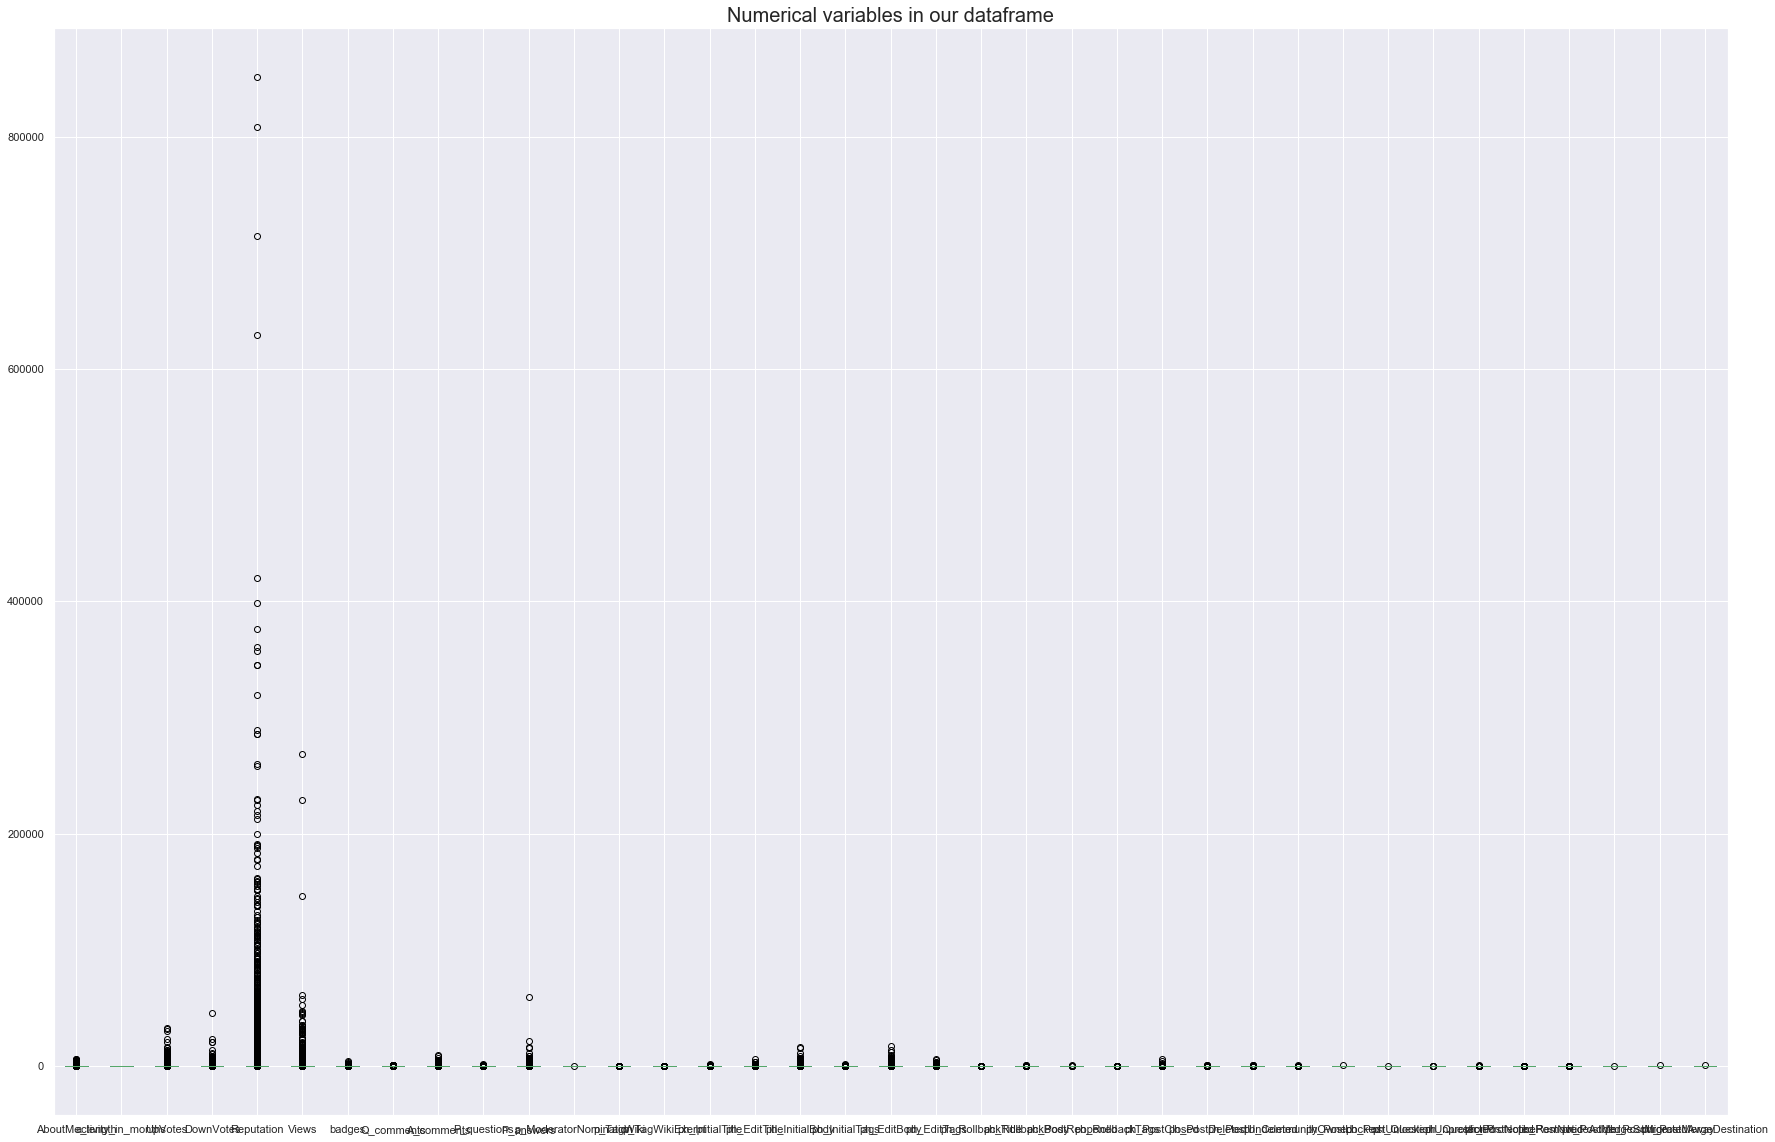

In [11]:
num_cols = ['AboutMe_length','activity_in_months','UpVotes','DownVotes','Reputation','Views','badges','Q_comments','A_comments','P_questions','P_answers','p_ModeratorNomination','p_TagWiki','p_TagWikiExerpt','ph_InitialTitle','ph_EditTitle','ph_InitialBody','ph_InitialTags','ph_EditBody','ph_EditTags','ph_RollbackTitle','ph_RollbackBody','ph_PostReopened','ph_RollbackTags','ph_PostClosed','ph_PostDeleted','ph_PostUndeleted','ph_CommunityOwned','ph_PostLocked','ph_PostUnlocked','ph_QuestionUnprotected','ph_QuestionProtected','ph_PostNoticeRemoved','ph_PostNoticeAdded','ph_PostMergeSource','ph_PostMigratedAway','ph_PostMergeDestination']
plt.figure(figsize=(30,20))
df[num_cols].boxplot()
plt.title("Numerical variables in our dataframe", fontsize=20)
plt.show()

In [12]:
# View each column seperately

# num_cols = ['Reputation']
# plt.figure(figsize=(20,15))
# df[num_cols].boxplot()
# plt.title("Numerical variables in our dataframe", fontsize=20)
# plt.show()

In [13]:
df[df.Reputation > 600000]

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination
77574,1144035,usa,325.0,93.0,13917,41,851064,268394,843,NaN,NaN,0.0,59042.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82886,335858,usa,353.0,113.4,29715,3088,629275,57897,2165,271.0,9548.0,21.0,15865.0,NaN,1.0,1.0,21.0,516.0,15888.0,21.0,8221.0,194.0,1.0,21.0,101.0,2.0,295.0,442.0,442.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
84878,115145,usa,3740.0,124.8,10836,6919,808485,228995,4097,NaN,NaN,110.0,21440.0,NaN,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85942,34397,usa,2320.0,131.6,6987,3253,714584,146079,3639,921.0,8302.0,51.0,15119.0,1.0,1.0,1.0,51.0,171.0,15173.0,51.0,4076.0,672.0,NaN,71.0,7.0,2.0,49.0,124.0,127.0,4.0,NaN,1.0,NaN,20.0,NaN,NaN,NaN,NaN,NaN


In [14]:
df[df.Views > 100000]

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination
77574,1144035,usa,325.0,93.0,13917,41,851064,268394,843,NaN,NaN,0.0,59042.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84878,115145,usa,3740.0,124.8,10836,6919,808485,228995,4097,NaN,NaN,110.0,21440.0,NaN,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85942,34397,usa,2320.0,131.6,6987,3253,714584,146079,3639,921.0,8302.0,51.0,15119.0,1.0,1.0,1.0,51.0,171.0,15173.0,51.0,4076.0,672.0,NaN,71.0,7.0,2.0,49.0,124.0,127.0,4.0,NaN,1.0,NaN,20.0,NaN,NaN,NaN,NaN,NaN


In [15]:
df[df.P_answers > 50000]

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination
77574,1144035,usa,325.0,93.0,13917,41,851064,268394,843,NaN,NaN,0.0,59042.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df[df.DownVotes > 30000]

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination
85524,62576,usa,2171.0,128.7,11643,45436,109919,35344,523,618.0,2357.0,8.0,2483.0,NaN,NaN,NaN,8.0,1184.0,2491.0,8.0,3636.0,1610.0,100.0,199.0,10.0,21.0,71.0,71.0,71.0,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN


In [17]:
df.at[[77574,82886,84878,85942],'Reputation'] = None;
df.at[[77574,84878,85942],'Views'] = None;
df.at[[77574],'P_answers'] = None;
df.at[[85524],'DownVotes'] = None;

In [18]:
# Create training and testing sets
df_train,df_test= train_test_split(df, test_size = 0.2, random_state = 0)

# Part 1: Exploratory Data Analysis

## 1.1 Overview of features and relation to target

Let's get a first overview of the train and test dataset
* How many rows and columns are there?  
* What are the names of the features (columns)?  
* Which features are numerical, which are categorical?  
* How many values are missing?  
The **shape** and **info** methods answer these questions. Whereas, the **head** displays some rows of the dataset **describe** gives a summary of the statistics (only for numerical columns)

### Shape, Info, Head & Describe -----> Functions

In [19]:
print('-'*100)
print('training sample size')
print(df_train.shape)
print('-'*100)
print('testing sample size')
print(df_test.shape)
print('-'*100)
print('training sample features description')
print(df_train.info())
print('-'*100)
print('testing sample features description')
print(df_train.info())
print('-'*100)

----------------------------------------------------------------------------------------------------
training sample size
(112147, 39)
----------------------------------------------------------------------------------------------------
testing sample size
(28037, 39)
----------------------------------------------------------------------------------------------------
training sample features description
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112147 entries, 8441 to 43567
Data columns (total 39 columns):
Id                         112147 non-null int64
country                    112147 non-null object
AboutMe_length             72567 non-null float64
activity_in_months         112147 non-null float64
UpVotes                    112147 non-null int64
DownVotes                  112146 non-null float64
Reputation                 112144 non-null float64
Views                      112145 non-null float64
badges                     112147 non-null int64
Q_comments                 298

* It seems like the trainning and tesing dataframe *(df)* vector *(vec)* consists of 39 columns (38 features excluding Id), as for the training df vec, it has 112147 entries (number of rows). On the other hand,  df test vec has 28037 entries.  
* There are lots of info that is probably related to the dependent variables - > target (questions and answers) such as badges, reputaion, etc...   
* Maybe other features are not so important for predicting the target, also there might be a strong correlation for some of the features (like activity_in_month).
* There are missing in some columns and it seems some countries tend to have more missing data than others, we are going to deal with missing data accordingly in a later stage

In [20]:
# displaying a sample from the training dataframe
df_train.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination
8441,6406742,usa,0.0,0.0,0,0.0,1.0,0.0,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71219,402309,usa,65.0,76.8,12,0.0,71.0,54.0,11,6.0,3.0,12.0,3.0,NaN,NaN,NaN,12.0,NaN,15.0,12.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91713,8745370,china,NaN,2.6,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15695,8980446,usa,NaN,0.8,0,0.0,1.0,0.0,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72968,974502,usa,0.0,80.9,7,0.0,333.0,13.0,6,NaN,NaN,0.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# displaying a descriptive stats regarding the training dataframe 
df_train.describe()

,Id,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination
count,1.121470e+05,72567.000000,112147.000000,112147.000000,112146.000000,112144.000000,112145.000000,112147.000000,29880.000000,29880.000000,83111.000000,82711.000000,18.000000,639.000000,782.000000,30676.000000,7457.000000,37948.000000,30672.000000,22936.000000,7423.000000,269.000000,943.000000,84.000000,329.000000,124.000000,2914.000000,2936.000000,956.000000,6.000000,6.000000,19.000000,72.000000,1109.000000,1844.000000,5.000000,5.000000,5.000000
mean,5.254029e+06,103.525253,33.385235,53.412922,5.640923,524.211915,61.093477,8.762972,7.093273,14.362483,5.081337,14.726929,1.444444,3.336463,3.372123,9.698559,11.369720,30.030041,9.695716,31.791725,15.943823,3.962825,5.135737,20.023810,2.714286,167.588710,3.586479,3.626022,3.789749,115.166667,13.833333,4.526316,15.861111,2.036970,2.399132,81.200000,66.000000,246.800000
std,3.493744e+06,240.822091,35.728919,366.203056,138.085672,5361.241449,689.483006,34.372489,21.792996,120.308331,20.267219,152.656942,0.855585,8.367411,10.869657,28.613973,104.543527,176.049231,28.608055,254.843311,117.261008,11.919448,24.004614,57.844198,6.676118,695.274865,15.982254,17.237171,34.506737,179.208724,15.791348,9.057645,77.046594,3.491284,4.871225,114.707018,131.556072,340.281795
min,3.200000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,10.000000,1.000000,28.000000
25%,2.039419e+06,0.000000,2.400000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,25.000000,3.750000,1.000000,1.000000,1.000000,1.000000,17.000000,1.000000,61.000000
50%,4.943085e+06,22.000000,19.400000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,4.000000,3.000000,4.000000,2.000000,1.000000,1.000000,4.000000,1.000000,13.000000,1.000000,1.000000,1.000000,43.500000,8.500000,1.000000,2.000000,1.000000,1.000000,43.000000,9.000000,147.000000
75%,8.321042e+06,99.000000,58.500000,4.000000,0.000000,57.000000,13.000000,6.000000,6.000000,4.000000,3.000000,4.000000,1.750000,2.000000,2.000000,8.000000,4.000000,16.000000,8.000000,12.000000,5.000000,3.000000,3.000000,17.250000,2.000000,63.000000,2.000000,2.000000,2.000000,92.000000,15.500000,2.000000,8.250000,2.000000,2.000000,52.000000,18.000000,150.000000
max,1.200456e+07,5687.000000,134.900000,32909.000000,20681.000000,420204.000000,61068.000000,4097.000000,618.000000,9548.000000,1107.000000,21440.000000,4.000000,107.000000,227.000000,1082.000000,6279.000000,15888.000000,1080.000000,17399.000000,5527.000000,135.000000,510.000000,465.000000,79.000000,5767.000000,442.000000,518.000000,1019.000000,474.000000,44.000000,37.000000,654.000000,56.000000,143.000000,284.000000,301.000000,848.000000


In [22]:
# displaying a sample from the testing dataframe
df_test.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination
36852,1749828,usa,73.0,13.7,0,0.0,1.0,6.0,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582,8938873,usa,546.0,0.0,0,0.0,1.0,0.0,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22587,9157667,usa,NaN,2.7,0,0.0,1.0,0.0,0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32320,3818420,usa,0.0,8.8,0,0.0,1.0,22.0,1,0.0,0.0,1.0,0.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71939,2184400,usa,0.0,78.5,0,0.0,11.0,2.0,1,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# displaying a descriptive stats regarding the testing dataframe
df_test.describe()

,Id,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination
count,2.803700e+04,18176.000000,28037.000000,28037.000000,28037.000000,28036.000000,28036.000000,28037.000000,7467.000000,7467.000000,20637.000000,20604.000000,2.000000,158.000000,170.000000,7643.000000,1874.000000,9505.000000,7643.000000,5711.000000,1854.000000,64.00000,230.000000,10.000000,84.000000,20.000000,725.000000,730.000000,218.000000,0.0,1.0,2.000000,12.000000,248.000000,416.000000,0.0,0.0,0.0
mean,5.239790e+06,104.350627,33.369383,51.202340,5.761244,478.127515,53.825938,8.553305,7.094549,13.891657,5.119639,13.689769,1.500000,2.829114,3.141176,9.729426,9.936499,29.553603,9.726809,28.674313,14.967098,3.50000,4.121739,11.600000,2.345238,52.150000,2.835862,2.813699,2.027523,NaN,1.0,1.500000,5.916667,2.056452,2.302885,NaN,NaN,NaN
std,3.504868e+06,241.465542,35.801144,308.907702,177.666834,4882.015740,531.233457,36.564736,25.737687,128.507173,23.416768,143.631424,0.707107,5.408407,7.790379,33.917419,76.470191,209.248327,33.891701,189.576509,140.036452,10.41519,12.936289,13.031586,4.073109,111.534406,8.565434,8.596157,4.572929,NaN,NaN,0.707107,6.570711,3.099699,3.169066,NaN,NaN,NaN
min,2.900000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.0,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN
25%,2.002042e+06,0.000000,2.400000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.250000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.250000,1.000000,1.750000,1.000000,1.000000,1.000000,NaN,1.0,1.250000,1.000000,1.000000,1.000000,NaN,NaN,NaN
50%,4.884387e+06,22.000000,19.200000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.500000,1.000000,1.000000,3.000000,2.000000,4.000000,3.000000,4.000000,2.000000,1.00000,1.000000,8.000000,1.000000,5.000000,1.000000,1.000000,1.000000,NaN,1.0,1.500000,3.500000,1.000000,1.000000,NaN,NaN,NaN
75%,8.329836e+06,99.000000,58.700000,3.000000,0.000000,56.000000,13.000000,6.000000,5.000000,4.000000,3.000000,4.000000,1.750000,2.000000,2.000000,8.000000,4.000000,16.000000,8.000000,11.000000,4.000000,2.00000,2.000000,14.500000,2.000000,46.000000,2.000000,2.000000,2.000000,NaN,1.0,1.750000,7.250000,2.000000,2.000000,NaN,NaN,NaN
max,1.200465e+07,5106.000000,134.900000,15748.000000,23492.000000,398955.000000,46946.000000,3639.000000,921.000000,8302.000000,1686.000000,15119.000000,2.000000,47.000000,75.000000,1686.000000,3010.000000,15173.000000,1686.000000,9757.000000,4922.000000,78.00000,140.000000,35.000000,33.000000,471.000000,151.000000,151.000000,62.000000,NaN,1.0,2.000000,20.000000,40.000000,42.000000,NaN,NaN,NaN


## Distribution of target variables (Questions and Answers)

In [24]:
## optimising plots size
# data = np.random.normal(0, 1, 3)
# array([-1.18878589,  0.59627021,  1.59895721])
# ploty = plt.figure(figsize=(20, 15))
# sns.boxplot(x=data);

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Skewness: 17.043771
Kurtosis: 523.860595
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


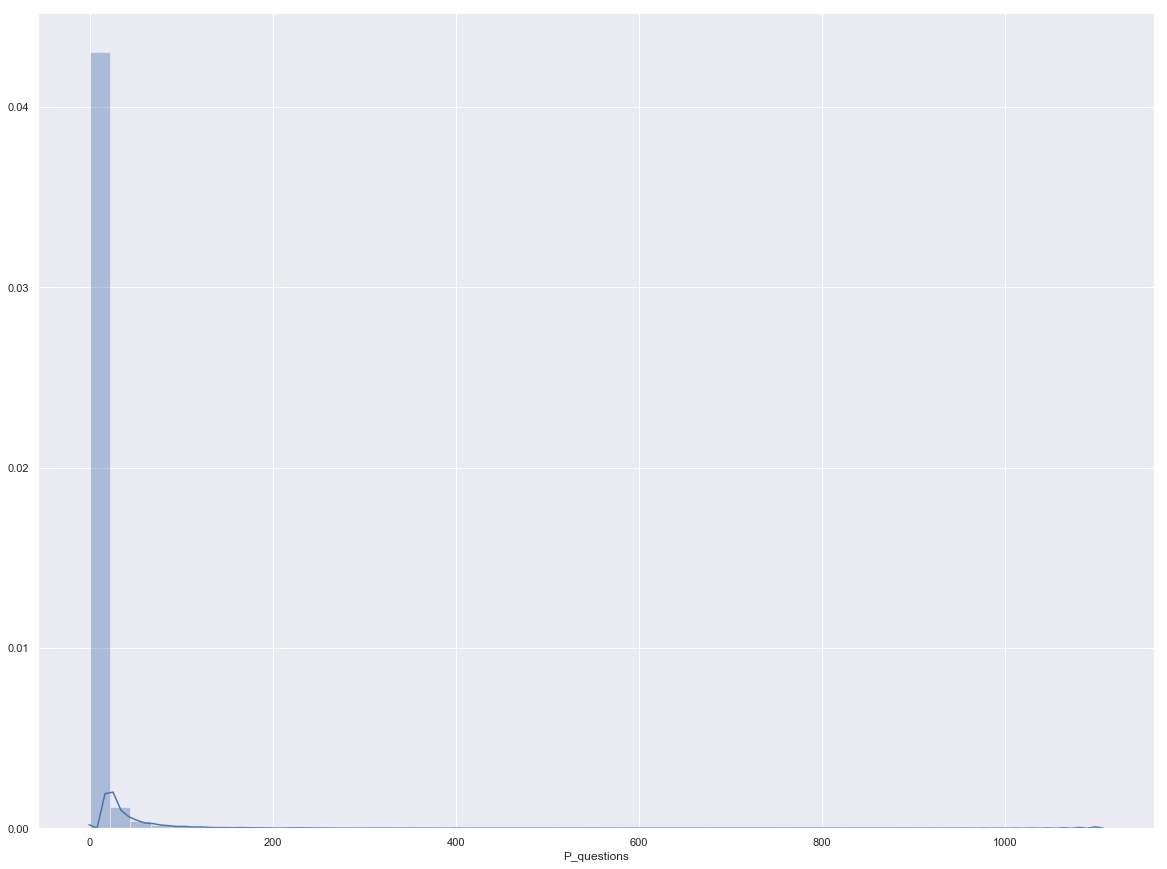

In [25]:
# ~ conversion error prevention **
# df_train = df_train.fillna(0)
# Seaborn 0_0
print('-'*100)
print('-'*100)
plt.figure(figsize=(20, 15))
sns.distplot(df_train['P_questions'].dropna());
# skewness and Kurtosis
print("Skewness: %f" % df_train['P_questions'].skew());
print("Kurtosis: %f" % df_train['P_questions'].kurt());
print('-'*100)
print('-'*100)
# ValueError: cannot convert float NaN to integer --- Error --- just drop NaN or convertion is required ---> utilising fillna in early phase

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Skewness: 65.700315
Kurtosis: 6939.023031
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


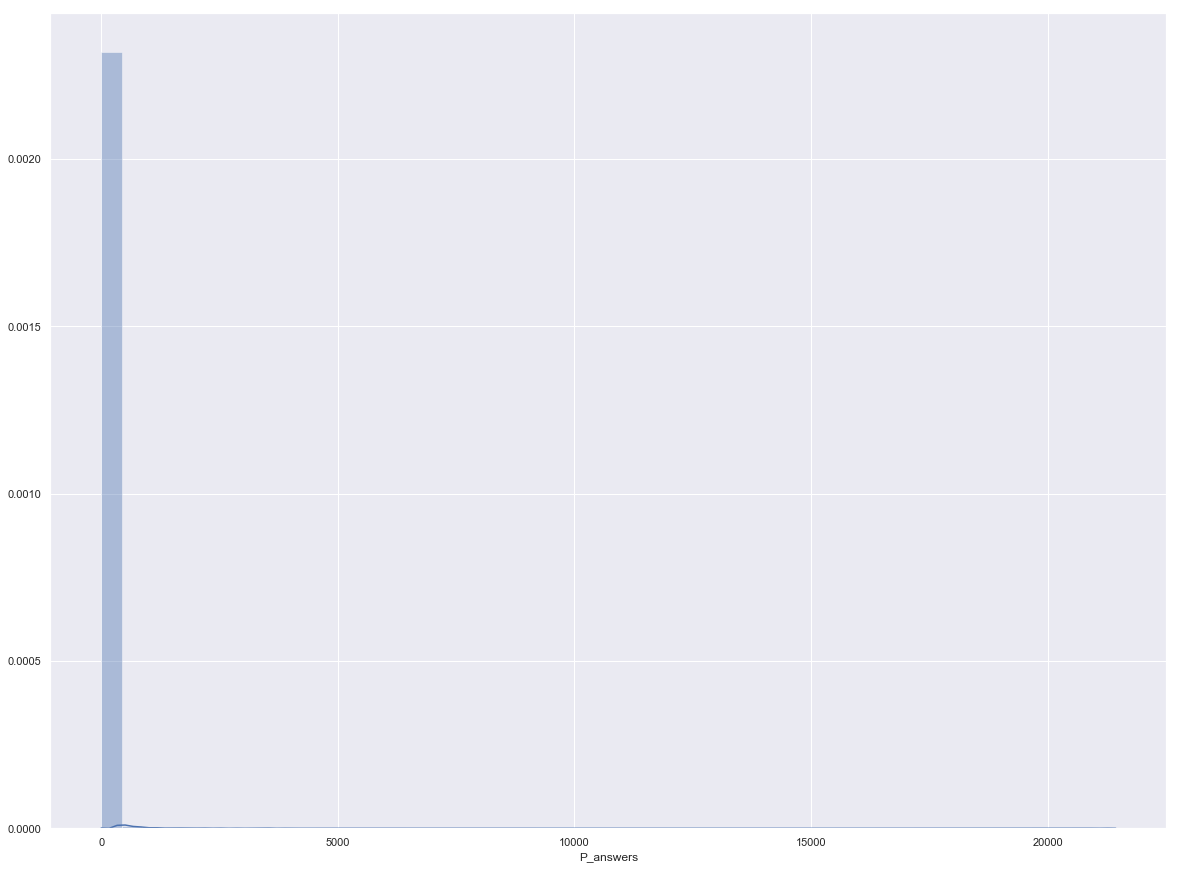

In [26]:
print('-'*100)
print('-'*100)
plt.figure(figsize=(20, 15))
sns.distplot(df_train['P_answers'].dropna());
# skewness and Kurtosis
print("Skewness: %f" % df_train['P_answers'].skew());
print("Kurtosis: %f" % df_train['P_answers'].kurt());
print('-'*100)
print('-'*100)

* As we can see, the target variable for both questions and answers is not normally distributed. 
* This behaviour can leads to performance reduction in the ML regression modeling due the fact that some models assume normal distribution.
* Therfore a log transformation is required (ref: see sklearn info on preprocessing) to enhance distribution visualisation.
* Before running log transformation, we need to deal with zero values in questions and answers otherwise will face the error due to zero division which will produce -1nf (minus infinity)

In [27]:
np.seterr(divide = 'ignore')
df_train['Questions_log'] = np.where(df_train.loc[:,['P_questions']]>0, np.log(df_train.loc[:,['P_questions']]), 0)
df_train['Answers_log'] = np.where(df_train.loc[:,['P_answers']]>0, np.log(df_train.loc[:,['P_answers']]), 0)


# # alternative implementation to avoids warnings.
# loc = np.where(myarray>0)
# result2 = np.zeros_like(myarray, dtype=float)
# result2[loc] =np.log(myarray[loc])

# # answer
# myarray= np.random.randint(10,size=10)
# result = np.where(myarray>0, np.log(myarray), 0)

# # check it is giving right solution:
# print(np.allclose(result, result2))

# append columns
# df_train = pd.concat([df_train, Questions_log], axis=1)

C:\Users\alamo248\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\alamo248\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
df_train.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination,Questions_log,Answers_log
8441,6406742,usa,0.0,0.0,0,0.0,1.0,0.0,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
71219,402309,usa,65.0,76.8,12,0.0,71.0,54.0,11,6.0,3.0,12.0,3.0,NaN,NaN,NaN,12.0,NaN,15.0,12.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.484907,1.098612
91713,8745370,china,NaN,2.6,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
15695,8980446,usa,NaN,0.8,0,0.0,1.0,0.0,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
72968,974502,usa,0.0,80.9,7,0.0,333.0,13.0,6,NaN,NaN,0.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2.833213


----------------------------------------------------------------------------------------------------


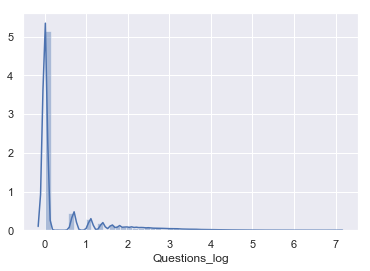

In [29]:
sns.distplot(df_train['Questions_log'].dropna());
print('-'*100)

----------------------------------------------------------------------------------------------------


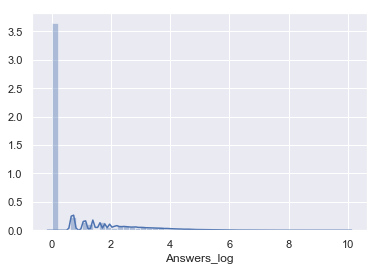

In [30]:
sns.distplot(df_train['Answers_log'].dropna());
print('-'*100)

In [31]:
print("-"*100)
print("Skewness and kurtosis for questions log")
print("Skewness: %f" % df_train['Questions_log'].skew());
print("Kurtosis: %f" % df_train['Questions_log'].kurt());
print("-"*100)

----------------------------------------------------------------------------------------------------
Skewness and kurtosis for questions log
Skewness: 2.164993
Kurtosis: 4.456871
----------------------------------------------------------------------------------------------------


In [32]:
print("-"*100)
print("Skewness and kurtosis for answers log")
print("Skewness: %f" % df_train['Answers_log'].skew());
print("Kurtosis: %f" % df_train['Questions_log'].kurt());
print("-"*100)

----------------------------------------------------------------------------------------------------
Skewness and kurtosis for answers log
Skewness: 2.259019
Kurtosis: 4.456871
----------------------------------------------------------------------------------------------------


In [33]:
print("Dropping old features from the loaded dataframe")
df_train.drop("P_questions",axis=1,inplace=True);
df_train.drop("P_answers",axis=1,inplace=True);

Dropping old features from the loaded dataframe


C:\Users\alamo248\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [34]:
df_train.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination,Questions_log,Answers_log
8441,6406742,usa,0.0,0.0,0,0.0,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
71219,402309,usa,65.0,76.8,12,0.0,71.0,54.0,11,6.0,3.0,NaN,NaN,NaN,12.0,NaN,15.0,12.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.484907,1.098612
91713,8745370,china,NaN,2.6,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
15695,8980446,usa,NaN,0.8,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
72968,974502,usa,0.0,80.9,7,0.0,333.0,13.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2.833213


In [35]:
print("-"*100)
print("Counting numerical and categorical features exist in the dataframe")
print("-"*100)
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of numerical features: ", len(numerical_feats));
categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of categorical features: ", len(categorical_feats));
print("-"*100)

----------------------------------------------------------------------------------------------------
Counting numerical and categorical features exist in the dataframe
----------------------------------------------------------------------------------------------------
Number of numerical features:  38
Number of categorical features:  1
----------------------------------------------------------------------------------------------------


In [36]:
print("-"*35)
print("Displaying numerical features")
print("-"*35)
print(df_train[numerical_feats].columns)
print("-"*35)
print("Displaying categorical features")
print("-"*35)
print(df_train[categorical_feats].columns)

-----------------------------------
Displaying numerical features
-----------------------------------
Index(['Id', 'AboutMe_length', 'activity_in_months', 'UpVotes', 'DownVotes',
       'Reputation', 'Views', 'badges', 'Q_comments', 'A_comments',
       'p_ModeratorNomination', 'p_TagWiki', 'p_TagWikiExerpt',
       'ph_InitialTitle', 'ph_EditTitle', 'ph_InitialBody', 'ph_InitialTags',
       'ph_EditBody', 'ph_EditTags', 'ph_RollbackTitle', 'ph_RollbackBody',
       'ph_PostReopened', 'ph_RollbackTags', 'ph_PostClosed', 'ph_PostDeleted',
       'ph_PostUndeleted', 'ph_CommunityOwned', 'ph_PostLocked',
       'ph_PostUnlocked', 'ph_QuestionUnprotected', 'ph_QuestionProtected',
       'ph_PostNoticeRemoved', 'ph_PostNoticeAdded', 'ph_PostMergeSource',
       'ph_PostMigratedAway', 'ph_PostMergeDestination', 'Questions_log',
       'Answers_log'],
      dtype='object')
-----------------------------------
Displaying categorical features
-----------------------------------
Index(['country'

In [37]:
print("-"*40)
print("Displaying numerical features dataframe")
print("-"*40)
df_train[numerical_feats].head()

----------------------------------------
Displaying numerical features dataframe
----------------------------------------


,Id,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination,Questions_log,Answers_log
8441,6406742,0.0,0.0,0,0.0,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
71219,402309,65.0,76.8,12,0.0,71.0,54.0,11,6.0,3.0,NaN,NaN,NaN,12.0,NaN,15.0,12.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.484907,1.098612
91713,8745370,NaN,2.6,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
15695,8980446,NaN,0.8,0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
72968,974502,0.0,80.9,7,0.0,333.0,13.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2.833213


In [38]:
print("-"*40)
print("Displaying categorical features")
print("-"*40)
df_train[categorical_feats].head()

----------------------------------------
Displaying categorical features
----------------------------------------


,country
8441,usa
71219,usa
91713,china
15695,usa
72968,usa


In [39]:
print("-"*40)
print("List features with missing values and their percentage")
print("-"*40)
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

----------------------------------------
List features with missing values and their percentage
----------------------------------------


,Total,Percent
ph_PostMergeDestination,112142,0.999955
ph_PostMigratedAway,112142,0.999955
ph_PostMergeSource,112142,0.999955
ph_PostLocked,112141,0.999946
ph_PostUnlocked,112141,0.999946
p_ModeratorNomination,112129,0.999839
ph_QuestionUnprotected,112128,0.999831
ph_QuestionProtected,112075,0.999358
ph_PostReopened,112063,0.999251
ph_PostClosed,112023,0.998894


## Filling missing values
* we have a few columns with a large percentage of NaN entries.

In [40]:
# cols_fillna = ['A_comments','Q_comments','AboutMe_length']
# # replace 'NaN' with zero in these columns
# for col in cols_fillna:
#     df_train[col].fillna(0,inplace=True)
#     df_test[col].fillna(0,inplace=True)
#################################################
# subtitute missing values by zero
df_train = df_train.fillna(0)

In [41]:
print("-"*40)
print("List features after handeling missing values")
print("-"*40)
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

----------------------------------------
List features after handeling missing values
----------------------------------------


,Total,Percent
Answers_log,0,0.0
Q_comments,0,0.0
ph_InitialBody,0,0.0
ph_EditTitle,0,0.0
ph_InitialTitle,0,0.0
p_TagWikiExerpt,0,0.0
p_TagWiki,0,0.0
p_ModeratorNomination,0,0.0
A_comments,0,0.0
badges,0,0.0


In [42]:
print("-"*40)
print("Missing values in train data ?")
print("-"*40)
df_train.isnull().sum().sum()

----------------------------------------
Missing values in train data ?
----------------------------------------


0

In [43]:
print("-"*40)
print("Missing values in test data ?")
print("-"*40)
df_train.isnull().sum().sum()

----------------------------------------
Missing values in test data ?
----------------------------------------


0

## log transform

* Like the target features, other features are not normally distributed therefore it is better to tranform those features using log in df_train and df_test. 

In [44]:
print("-"*40)
print("Checking for skewness and kurtosis:")
print("-"*40)

for col in numerical_feats:
    print('{:25}'.format(col),'    ', 
          'Skewness: {:05.2f}'.format(df_train[col].skew()) , 
          '-------->' ,
          'Kurtosis: {:05.2f}'.format(df_train[col].kurt())  
         )

----------------------------------------
Checking for skewness and kurtosis:
----------------------------------------
Id                             Skewness: 00.14 --------> Kurtosis: -1.29
AboutMe_length                 Skewness: 07.16 --------> Kurtosis: 80.83
activity_in_months             Skewness: 00.95 --------> Kurtosis: -0.19
UpVotes                        Skewness: 31.72 --------> Kurtosis: 1963.95
DownVotes                      Skewness: 85.96 --------> Kurtosis: 10389.11
Reputation                     Skewness: 36.52 --------> Kurtosis: 1885.22
Views                          Skewness: 45.50 --------> Kurtosis: 2749.44
badges                         Skewness: 31.92 --------> Kurtosis: 2409.27
Q_comments                     Skewness: 19.71 --------> Kurtosis: 602.85
A_comments                     Skewness: 72.67 --------> Kurtosis: 7927.83
p_ModeratorNomination          Skewness: 121.23 --------> Kurtosis: 17850.58
p_TagWiki                      Skewness: 90.58 --------> Kurt

In [45]:
list(set(df_train.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]

In [46]:
df_num = df_train.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,Id,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination,Questions_log,Answers_log
8441,6406742,0.0,0.0,0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
71219,402309,65.0,76.8,12,0.0,71.0,54.0,11,6.0,3.0,0.0,0.0,0.0,12.0,0.0,15.0,12.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.484907,1.098612
91713,8745370,0.0,2.6,0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
15695,8980446,0.0,0.8,0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
72968,974502,0.0,80.9,7,0.0,333.0,13.0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.833213


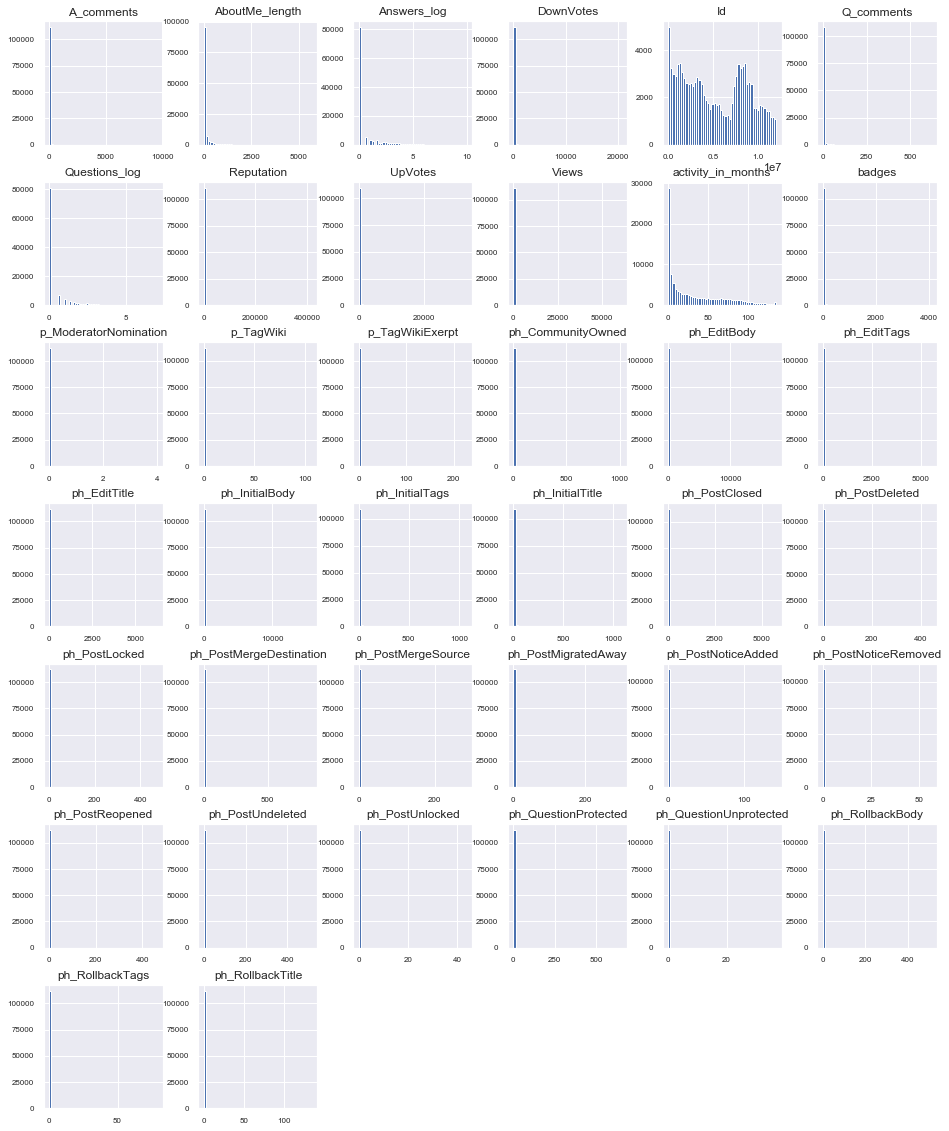

In [47]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## 1.2 Relation of features to target (Questions_log and Answers_log)
### Plots of relation to target for all numerical features

In [48]:
# nr_rows = 12
# nr_cols = 3

# fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

# li_num_feats = list(numerical_feats)
# li_not_plot = ['Id', 'Questions_log']
# li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


# for r in range(0,nr_rows):
#     for c in range(0,nr_cols):  
#         i = r*nr_cols+c
#         if i < len(li_plot_num_feats):
#             sns.regplot(df_train[li_plot_num_feats[i]], df_train[target_1], ax = axs[r][c])
#             stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target_1])
#             #axs[r][c].text(0.4,0.9,"title",fontsize=7)
#             str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
#             axs[r][c].set_title(str_title,fontsize=11)
            
# plt.tight_layout()    
# plt.show()   

In [49]:
# nr_rows = 12
# nr_cols = 3

# fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

# li_num_feats = list(numerical_feats)
# li_not_plot = ['Id', 'Answers_log']
# li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


# for r in range(0,nr_rows):
#     for c in range(0,nr_cols):  
#         i = r*nr_cols+c
#         if i < len(li_plot_num_feats):
#             sns.regplot(df_train[li_plot_num_feats[i]], df_train[target_2], ax = axs[r][c])
#             stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target_2])
#             #axs[r][c].text(0.4,0.9,"title",fontsize=7)
#             str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
#             axs[r][c].set_title(str_title,fontsize=11)
            
# plt.tight_layout()    
# plt.show()  

### List of numerical features and their correlation coefficient to target

**Find columns with strong correlation to target**  
Only those with r > min_val_corr are used in the ML Regressors in Part 3  
The value for min_val_corr can be chosen in global settings

In [50]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target_1)[target_1]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [51]:
print(ser_corr)
print("-"*100)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("-"*100)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

Questions_log              1.000000
Answers_log                0.583457
activity_in_months         0.519317
ph_InitialTitle            0.517934
ph_InitialTags             0.517899
badges                     0.486148
Q_comments                 0.461971
Id                         0.375325
UpVotes                    0.310043
ph_InitialBody             0.212982
Reputation                 0.199369
ph_PostNoticeAdded         0.194436
Views                      0.186966
ph_PostNoticeRemoved       0.169843
ph_EditBody                0.122809
A_comments                 0.122552
AboutMe_length             0.099355
DownVotes                  0.078457
ph_PostDeleted             0.077059
ph_EditTags                0.076123
ph_PostUndeleted           0.073777
p_TagWiki                  0.065818
ph_EditTitle               0.060577
p_TagWikiExerpt            0.055732
ph_RollbackTags            0.049139
ph_RollbackBody            0.043254
ph_RollbackTitle           0.036032
ph_CommunityOwned          0

In [52]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target_2)[target_2]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [53]:
print(ser_corr)
print("-"*100)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("-"*100)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

Answers_log                1.000000
activity_in_months         0.620181
Questions_log              0.583457
badges                     0.551554
Id                         0.435349
UpVotes                    0.430232
Reputation                 0.367235
Q_comments                 0.349821
ph_InitialBody             0.338061
ph_InitialTitle            0.316378
ph_InitialTags             0.316060
Views                      0.314861
A_comments                 0.261569
ph_EditBody                0.223013
DownVotes                  0.178076
AboutMe_length             0.170104
ph_PostNoticeAdded         0.169625
ph_PostNoticeRemoved       0.157813
ph_PostDeleted             0.151902
ph_EditTags                0.151212
ph_PostUndeleted           0.143958
ph_EditTitle               0.113681
p_TagWiki                  0.113267
p_TagWikiExerpt            0.092365
ph_RollbackBody            0.090631
ph_RollbackTags            0.088643
ph_RollbackTitle           0.071977
p_ModeratorNomination      0

### List of categorical features and their unique values

In [54]:
print('-'*100)
for catg in list(categorical_feats) :
    print(df_train[catg].value_counts())
    print('-'*100)

----------------------------------------------------------------------------------------------------
usa       69636
china     27968
russia    14543
Name: country, dtype: int64
----------------------------------------------------------------------------------------------------


### Relation to Questions and Answers for all categorical features

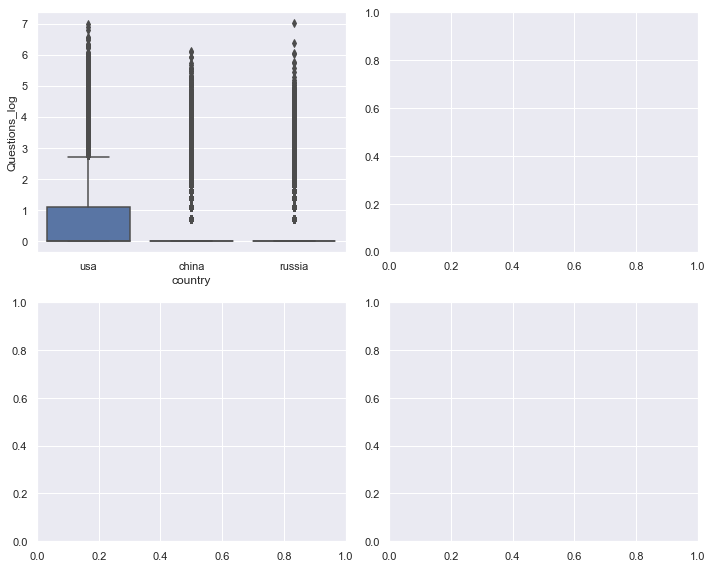

In [55]:
li_cat_feats = list(categorical_feats)
nr_rows = 2
nr_cols = 2
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*5,nr_rows*4))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target_1, data=df_train, ax = axs[r][c])
plt.tight_layout()    
plt.show()  

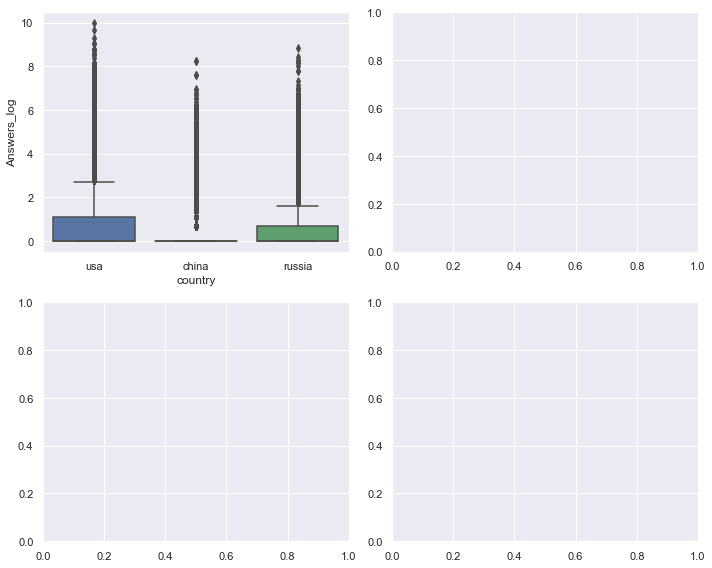

In [56]:
li_cat_feats = list(categorical_feats)
nr_rows = 2
nr_cols = 2
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*5,nr_rows*4))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target_2, data=df_train, ax = axs[r][c])
plt.tight_layout()    
plt.show()

### Correlation matrix 1
**Features with largest correlation to Questions_Log**  
all numerical features with correlation coefficient above threshold 

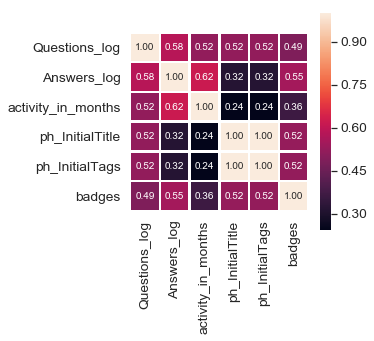

In [57]:
nr_feats = len(cols_abv_corr_limit)
plot_corr_matrix(df_train, nr_feats, target_1)

### Correlation matrix 1
**Features with largest correlation to Answers_Log**  
all numerical features with correlation coefficient above threshold 

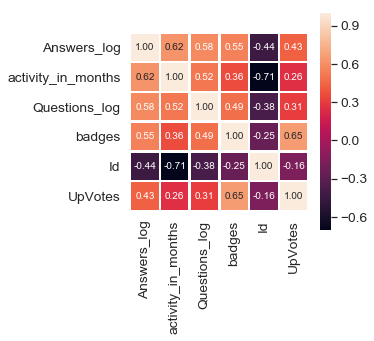

In [58]:
nr_feats = len(cols_abv_corr_limit)
plot_corr_matrix(df_train, nr_feats, target_2)

* Of those features with the largest correlation to questions and answers, some also are correlated strongly to each other.
* To avoid failures of the ML regression models due to multicollinearity, these are dropped in part 2.
* This is optional and controlled by the switch drop_similar (global settings)

# Part 2: Data wrangling

* Drop all columns with only small correlation to P_questions and P_answers
* Transform Categorical to numerical
* Handling columns with missing data if it is needed
* Log values
* Drop all columns with strong correlation to similar features

### Dropping all columns with weak correlation to Questions and Answers

In [59]:
id_test = df_test['Id']

to_drop_num  = cols_bel_corr_limit
# to_drop_catg = catg_weak_corr

cols_to_drop = ['Id'] + to_drop_num #+ to_drop_catg 

for df in [df_train, df_test]:
    df.drop(cols_to_drop, inplace= True, axis = 1)

### Convert categorical columns to numerical  
* We need to transform the country categorcial feature to numerical.
* To investigate the relation of the categorcial feature to target in more detail, we will create violinplots
* Also, we look at the mean of Questions and Answers as function of category.

In [60]:
# Since we have one categorical value then we will take it as it is
catg_strong_corr = [ 'country']
catg_list = catg_strong_corr.copy()

                                           Violinplots btween Questions and Country
-------------------------------------------------------------------------------------------------------------------------------


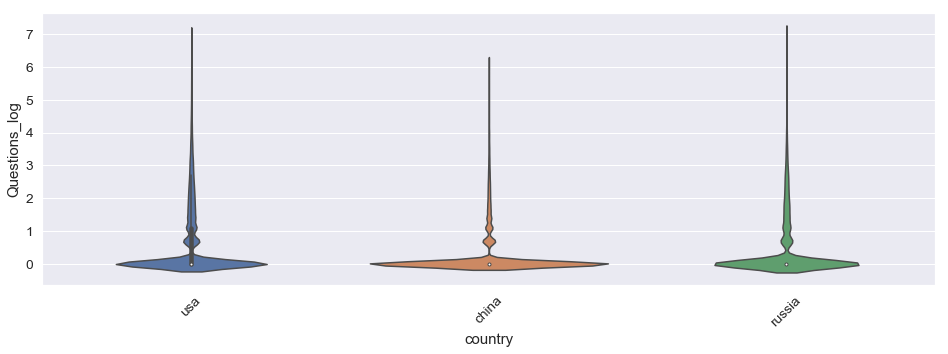

In [61]:
print(" "*43+"Violinplots btween Questions and Country")
print("-"*127)
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.violinplot(x='country', y=target_1, data=df_train, ax=ax)
plt.xticks(rotation=45)
plt.show()

                                           Violinplots btween Answers and Country
-------------------------------------------------------------------------------------------------------------------------------


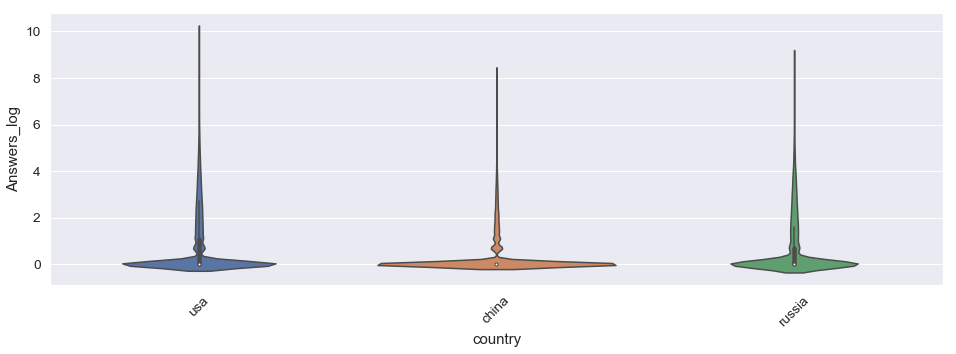

In [62]:
print(" "*43+"Violinplots btween Answers and Country")
print("-"*127)
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.violinplot(x='country', y=target_2, data=df_train, ax=ax)
plt.xticks(rotation=45)
plt.show()

In [63]:
for catg in catg_list :
    g1 = df_train.groupby(catg)[target_1].mean()
    g2 = df_train.groupby(catg)[target_2].mean()
    print(g1)
    print(g2)

country
china     0.254928
russia    0.431651
usa       0.617375
Name: Questions_log, dtype: float64
country
china     0.307254
russia    0.647612
usa       0.730959
Name: Answers_log, dtype: float64


In [64]:
# We are going to copy a country column then transform countries into integers and this can be done in different ways
# 'country'
country_catg2 = ['usa']
country_catg3 = ['china']
country_catg4 = ['russia']

In [65]:
for df in [df_train, df_test]:   
    df['country_num'] = 1  
    df.loc[(df['country'].isin(country_catg2) ), 'country_num'] = 2
    df.loc[(df['country'].isin(country_catg3) ), 'country_num'] = 3
    df.loc[(df['country'].isin(country_catg4) ), 'country_num'] = 4

## Checking correlation to questions and answers for the new numerical columns¶

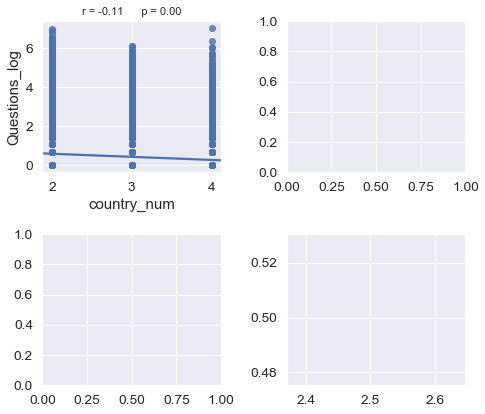

In [66]:
new_col_num = ['country_num']

nr_rows = 2
nr_cols = 2

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(new_col_num):
            sns.regplot(df_train[new_col_num[i]], df_train[target_1], ax = axs[r][c])
            stp = stats.pearsonr(df_train[new_col_num[i]], df_train[target_1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()  

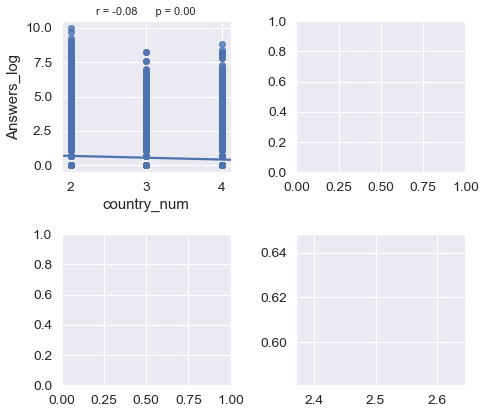

In [67]:
new_col_num = ['country_num']

nr_rows = 2
nr_cols = 2

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(new_col_num):
            sns.regplot(df_train[new_col_num[i]], df_train[target_2], ax = axs[r][c])
            stp = stats.pearsonr(df_train[new_col_num[i]], df_train[target_2])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show() 

In [68]:
# # dublicate column
dup = df_train['country_num']
# df_train['country_dum'] = df_train['country']
# df_train.head()
# # check data types 
# df_train["country_dum"] = df_train["country_dum"].astype('category')
# df_train.dtypes
# # create a new categorical dummy var from original
# df_train["country_dum1"] = df_train["country_dum"].cat.codes
# df_train.head()

In [69]:
df_train.head()

,country,activity_in_months,UpVotes,badges,Questions_log,Answers_log,country_num
8441,usa,0.0,0,0,0.000000,0.000000,2
71219,usa,76.8,12,11,2.484907,1.098612,2
91713,china,2.6,0,1,0.000000,0.000000,3
15695,usa,0.8,0,1,0.000000,0.000000,2
72968,usa,80.9,7,6,0.000000,2.833213,2


In [70]:
# check if the categorical conversion is correct, first convert the created country_num into list then loop through the list to see if the numbers adds up
cate = df_train['country_num'].tolist()

In [71]:
# check numerical values for the categorical feature have changed correctly
print('-'*100)
usa = 0
china = 0
russia = 0
for column in cate:
    if column == 2: 
        usa +=1
    elif column == 3:
        china +=1
    else:
        russia+=4
print("usa = ",usa)
print("china = ",china)
print("russia = ",russia)
print('-'*100)

----------------------------------------------------------------------------------------------------
usa =  69636
china =  27968
russia =  58172
----------------------------------------------------------------------------------------------------


* Dropping the converted categorical column and the new numerical columns with weak correlation
* These will probably be useful for optimal performance of the Regressors in part 3.

In [72]:
#catg_cols_to_drop = ['country']

corr1 = df_train.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(df_train)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, target_1)[target_1]
ser_corr_2 = corr_abs_1.nlargest(nr_all_cols, target_2)[target_2]
print("-"*100)
print(ser_corr_1)
print("-"*50)
print(ser_corr_2)
print("-"*100)

cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)
cols_bel_corr_limit_2 = list(ser_corr_2[ser_corr_2.values <= min_val_corr].index)

# for df in [df_train, df_test] :
#     df.drop(catg_cols_to_drop, inplace= True, axis = 1)
#     df.drop(cols_bel_corr_limit_1, inplace= True, axis = 1)    
#     df.drop(cols_bel_corr_limit_2, inplace= True, axis = 1)   

----------------------------------------------------------------------------------------------------
Questions_log         1.000000
Answers_log           0.583457
activity_in_months    0.519317
badges                0.486148
UpVotes               0.310043
country_num           0.114741
Name: Questions_log, dtype: float64
--------------------------------------------------
Answers_log           1.000000
activity_in_months    0.620181
Questions_log         0.583457
badges                0.551554
UpVotes               0.430232
country_num           0.077574
Name: Answers_log, dtype: float64
----------------------------------------------------------------------------------------------------


* It seems like country_num is weakly correlated with both Questions_log and Answers_log. However, the feature UpVotes is weakly correlated with Questions_log but this is not the case with Answers_log. Thus, we will keep it :)

In [73]:
df_train.drop(['country','country_num'], inplace= True, axis = 1)
df_test.drop(['country','country_num'], inplace= True, axis = 1)

In [77]:
corr2 = df_train.corr()
corr_abs_2 = corr2.abs()

nr_all_cols = len(df_train)
ser_corr_3 = corr_abs_2.nlargest(nr_all_cols, target_1)[target_1]
ser_corr_4 = corr_abs_2.nlargest(nr_all_cols, target_2)[target_2]

print("-"*100)
print(ser_corr_3)
print("-"*50)
print(ser_corr_4)
print("-"*100)

----------------------------------------------------------------------------------------------------
Questions_log         1.000000
Answers_log           0.583457
activity_in_months    0.519317
badges                0.486148
UpVotes               0.310043
Name: Questions_log, dtype: float64
--------------------------------------------------
Answers_log           1.000000
activity_in_months    0.620181
Questions_log         0.583457
badges                0.551554
UpVotes               0.430232
Name: Answers_log, dtype: float64
----------------------------------------------------------------------------------------------------


In [74]:
df_train.head()

,activity_in_months,UpVotes,badges,Questions_log,Answers_log
8441,0.0,0,0,0.000000,0.000000
71219,76.8,12,11,2.484907,1.098612
91713,2.6,0,1,0.000000,0.000000
15695,0.8,0,1,0.000000,0.000000
72968,80.9,7,6,0.000000,2.833213


In [78]:
df_test.head()

,country,activity_in_months,UpVotes,badges,P_questions,P_answers,country_num
36852,usa,13.7,0,1,0.0,0.0,2
582,usa,0.0,0,1,0.0,0.0,2
22587,usa,2.7,0,0,1.0,0.0,2
32320,usa,8.8,0,1,1.0,0.0,2
71939,usa,78.5,0,1,0.0,1.0,2


## Correlation Matrix 2 : All features with strong correlation to Questions_log
* need to fix df_test logs not created

In [75]:
# # create the independent variable vector
# x = df.iloc[:,6:15].values
# # Question dependent variable vector 
# y = df.iloc[:, -2:-1].values
# # Answer dependent variable vector 
# z = df.iloc[:,-1:].values
# # create labelEncoder object to transform categorical values into integers
# x[:, 0] = LabelEncoder().fit_transform(x[:, 0])
# y = LabelEncoder().fit_transform(y)
# z = LabelEncoder().fit_transform(z)
# # creating OneHotEncoder object to transform integer categorical values into dummy categorical
# x = OneHotEncoder(categorical_features=[0]).fit_transform(x).toarray()
# # Create training and testing sets
# x_train,x_test,y_train,y_test,z_train,z_test = train_test_split(x,y,z, test_size = 0.2, random_state = 0)
# # feature scaling
# sc_x = StandardScaler()
# x_train = sc_x.fit_transform(x_train)
# x_test = sc_x.transform(x_test)